<a href="https://colab.research.google.com/github/hiderbrandon/SimulationProject/blob/develop/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SIMULACION Y COMPUTACION NUMERICA

* Hider Brandon Vargas Cordoba 1740421



#necessary package

In [1]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

##downloading MNIST dataset

In [2]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 104716009.11it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 16440783.64it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 25421772.04it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8474434.51it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



**visualizing** data

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


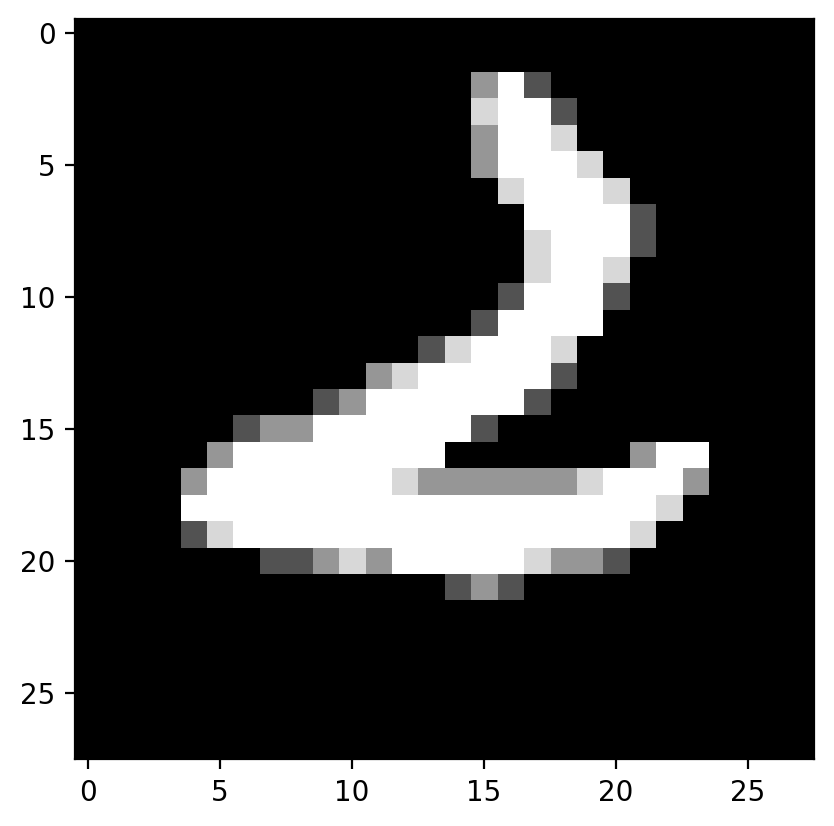

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');


#modeling wihtout nn package

##Exercise:
**Flatten** the batch of images images. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next.

In [21]:
def activation(x):
    return 1/(1+torch.exp(-x))

### Generate some data
torch.manual_seed(7) # Set the random seed so things are predictable

# Features are flattered image tensor
features = images.view(images.shape[0], 784)
print(f"features shape {features.shape}")

#layer 1 parameters
w1 = torch.rand(features.shape[1] , 256)
b1 = torch.randn(256)

#layer 2 parameters
w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(features, w1) + b1)

out = activation(torch.mm(h, w2) + b2)

print(f"output {out.shape}")

features shape torch.Size([64, 784])
output torch.Size([64, 10])


##Exercise:
Implement a function softmax that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor a with shape (64, 10) and a tensor b with shape (64,), doing a/b will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need b to have a shape of (64, 1). This way PyTorch will divide the 10 values in each row of a by the one value in each row of b. Pay attention to how you take the sum as well. You'll need to define the dim keyword in torch.sum. Setting dim=0 takes the sum across the rows while dim=1 takes the sum across the columns.

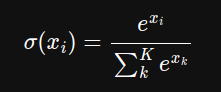

In [34]:
def softmax(x):
  denominator = torch.sum(torch.exp(x) , dim=1).view(torch.exp(x).shape[0], 1 )
  x_sum = torch.exp(x)/denominator
  print(f"x_sum {x_sum.shape}")

  return x_sum


print(f"softmax {softmax(out).shape}")


x_sum torch.Size([64, 10])
softmax torch.Size([64, 10])


#Building networks with PyTorch
PyTorch provides a module nn that makes building networks much simpler. Here I'll show you how to build the same one as above with 784 inputs, 256 hidden units, 10 output units and a softmax output.

###object module aproach


In [2]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)

        # Define sigmoid activation and softmax output
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)

        return x

In [3]:
# Create the network and look at its text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

###functional approach

You can define the network somewhat more concisely and clearly using the torch.nn.functional module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as F, import torch.nn.functional as F.

In [4]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)

        return x

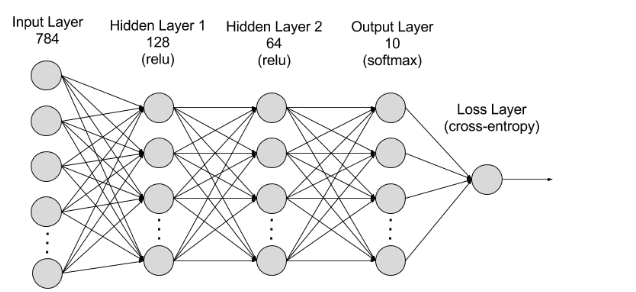
##Exercise:
Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the nn.ReLU module or F.relu function.

In [5]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        #defining layers
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Hidden layer with Relu activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output layer with Relu activation
        x = F.relu(self.fc3(x))

        return x


model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)